In [105]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
from sklearn.model_selection import train_test_split

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'CUDA enabled: {use_cuda}')

CUDA enabled: True


In [49]:
root = '../../datasets/ADAM'
fovea = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')

display(fovea.head())
display(fovea.tail())

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


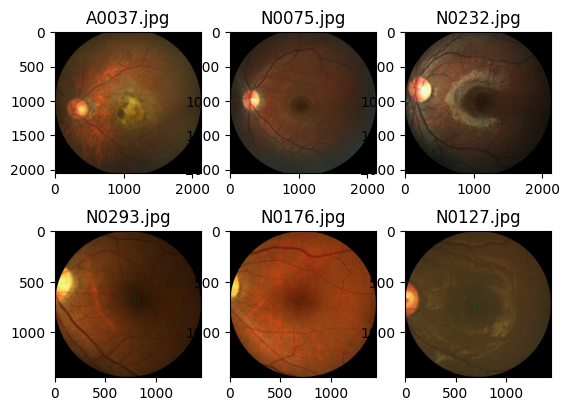

In [132]:
def load_image(df, idx, root='../../datasets/ADAM'):
	image_name = df.loc[idx, 'imgName']
	data_type = 'AMD' if image_name.startswith('A') else 'Non-AMD'
	image_path = f'{root}/{data_type}/{image_name}'
	image = Image.open(image_path)
	bbox = (df.loc[idx, 'Fovea_X'], df.loc[idx, 'Fovea_Y'])
	return image, bbox


def show_image_with_bbox(image, bbox, idx=None, ax=None):
	w, h = (50, 50)
	c_x, c_y = bbox
	image = image.copy()
	ImageDraw.Draw(image).rectangle(((c_x-w//2, c_y-h//2), (c_x+w//2, c_y+h//2)), outline='green', width=2)
	if ax is not None:
		ax.imshow(image)
		if idx is not None: ax.set_title(fovea.loc[idx, 'imgName'])
	else: 
		plt.imshow(image)
		if idx is not None: plt.title(fovea.loc[idx, 'imgName'])


def show_image_with_two_bboxes(image, target_bbox, eval_bbox, title, ax=None):
	w, h = (50, 50)
	t_c_x, t_c_y = target_bbox
	e_c_x, e_c_y = eval_bbox
	image = image.copy()
	ImageDraw.Draw(image).rectangle(((t_c_x-w//2, t_c_y-h//2), (t_c_x+w//2, t_c_y+h//2)), outline='green', width=2)
	ImageDraw.Draw(image).rectangle(((e_c_x-w//2, e_c_y-h//2), (e_c_x+w//2, e_c_y+h//2)), outline='red', width=2)
	if ax is not None:
		ax.imshow(image)
		ax.set_title(title)
	else: 
		plt.imshow(image)
		plt.title(title)


fig, axes = plt.subplots(2, 3)
to_draw = np.random.choice(fovea.index, size=6, replace=False)

for ax, idx in zip(axes.flatten(), to_draw):
	img, bbox = load_image(fovea, idx)
	show_image_with_bbox(img, bbox, ax=ax, idx=idx)

torch.float32 tensor(0.5294)


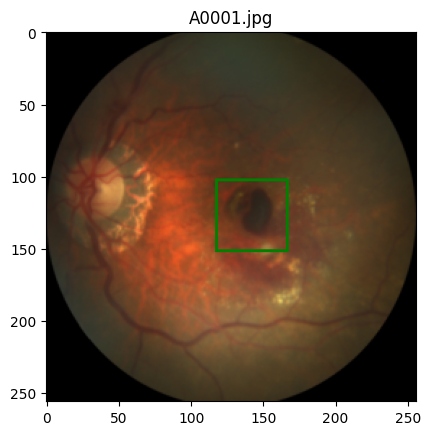

In [63]:
class Resize:
    '''Resize the image and convert the label
    to the new shape of the image'''
    def __init__(self, new_size=(256, 256)):
        self.new_width = new_size[0]
        self.new_height = new_size[1]

    def __call__(self, image_label_sample):
        image = image_label_sample[0]
        label = image_label_sample[1]
        c_x, c_y = label
        original_width, original_height = image.size
        image_new = torchvision.transforms.functional.resize(image, (self.new_width, self.new_height))
        c_x_new = c_x * self.new_width /original_width
        c_y_new = c_y * self.new_height / original_height
        return image_new, (c_x_new, c_y_new)


class ToTensor:
    '''Convert the image to a Pytorch tensor with
    the channel as first dimenstion and values 
    between 0 to 1. Also convert the label to tensor
    with values between 0 to 1'''
    def __init__(self, scale_label=True):
        self.scale_label = scale_label

    def __call__(self, image_label_sample):
        image = image_label_sample[0]
        label = image_label_sample[1]
        w, h = image.size
        c_x, c_y = label

        image = torchvision.transforms.functional.to_tensor(image)

        if self.scale_label:
            label = c_x/w, c_y/h
        label = torch.tensor(label, dtype=torch.float32)

        return image, label
  

class ToPILImage:
    '''Convert a tensor image to PIL Image. 
    Also convert the label to a tuple with
    values with the image units'''
    def __init__(self, unscale_label=True):
        self.unscale_label = unscale_label

    def __call__(self, image_label_sample):
        image = image_label_sample[0]
        label = image_label_sample[1].tolist()

        image = torchvision.transforms.functional.to_pil_image(image)
        w, h = image.size

        if self.unscale_label:
            c_x, c_y = label
            label = c_x*w, c_y*h

        return image, label


init_sample = load_image(fovea, 1)
transform = torchvision.transforms.Compose([Resize(), ToTensor()])
img, bbox = transform(init_sample)
print(img.dtype, img[0][100][100])
img, bbox = ToPILImage()((img, bbox))
show_image_with_bbox(img, bbox, idx=1)

dobrym pomyslem bedzie przeformatowanie tych obrazkow bezposrednio tutaj juz i zapisanie je w formacie [3, 255, 255] i bbox jako float zeby latwiej wczytywalo sie dane w tensorflowie i libtorchu

In [108]:
class ADAMDataset(torch.utils.data.Dataset):
	def __init__(self, root, transform, fovea_df=None):
		self.root = root
		self.transform = transform
		if fovea_df is None:
			self.fovea_df = pd.read_csv(f'{root}/fovea_location.csv', index_col='ID')
		else:
			self.fovea_df = fovea_df


	def __getitem__(self, index):
		image_name = self.fovea_df.loc[index, 'imgName']
		image_path = f"{self.root}/{('AMD' if image_name.startswith('A') else 'Non-AMD')}/{image_name}"
		image = Image.open(image_path)
		bbox = self.fovea_df.loc[index, ['Fovea_X','Fovea_Y']].values.astype(float)
		image, bbox = self.transform((image, bbox))
		return image, bbox


	def __len__(self):
		return len(self.fovea_df)
	

def get_adam_loaders(batch_size, test_batch_size=None, cutoff=1, root='../../datasets/ADAM'):
	if test_batch_size is None: test_batch_size = batch_size * 2

	transform = torchvision.transforms.Compose([Resize(), ToTensor()])

	fovea_df = pd.read_csv(f'{root}/fovea_location.csv').drop(['ID'], axis=1)
	train_df, test_df = train_test_split(fovea_df, test_size=1-cutoff, shuffle=True)

	train_ds = ADAMDataset(root, transform, fovea_df=train_df.reset_index())
	test_ds = ADAMDataset(root, transform, fovea_df=test_df.reset_index())

	train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
	test_dl = torch.utils.data.DataLoader(test_ds, batch_size=test_batch_size, shuffle=False, num_workers=2)

	return train_dl, test_dl


train_dl, test_dl = get_adam_loaders(8, cutoff=0.8)
print(len(train_dl))
image_batch, labels_batch = next(iter(train_dl))
print(image_batch.shape, image_batch.dtype)
print(labels_batch, labels_batch.dtype)

40
torch.Size([8, 3, 256, 256]) torch.float32
tensor([[0.5290, 0.5460],
        [0.6635, 0.6099],
        [0.4905, 0.5522],
        [0.5906, 0.5641],
        [0.5131, 0.4984],
        [0.5621, 0.4708],
        [0.5284, 0.5309],
        [0.4790, 0.5037]]) torch.float32


In [85]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.base1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True) 
        )
        self.base2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.base1(x) + x
        x = self.base2(x)
        return x
    

class FoveaNet(nn.Module):
    def __init__(self, in_channels, first_output_channels):
        super().__init__()
        self.main = nn.Sequential(
            ResBlock(in_channels, first_output_channels),
            nn.MaxPool2d(2),
            ResBlock(first_output_channels, 2 * first_output_channels),
            nn.MaxPool2d(2),
            ResBlock(2 * first_output_channels, 4 * first_output_channels),
            nn.MaxPool2d(2),
            ResBlock(4 * first_output_channels, 8 * first_output_channels),
            nn.MaxPool2d(2),
            nn.Conv2d(8 * first_output_channels, 16 * first_output_channels, kernel_size=3),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(7 * 7 * 16 * first_output_channels, 2)
        )

    def forward(self, x):
        return self.main(x)
	

model = FoveaNet(3, 16)
model = model.to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              84
       BatchNorm2d-2          [-1, 3, 256, 256]               6
              ReLU-3          [-1, 3, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]             448
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
          ResBlock-7         [-1, 16, 256, 256]               0
         MaxPool2d-8         [-1, 16, 128, 128]               0
            Conv2d-9         [-1, 16, 128, 128]           2,320
      BatchNorm2d-10         [-1, 16, 128, 128]              32
             ReLU-11         [-1, 16, 128, 128]               0
           Conv2d-12         [-1, 32, 128, 128]           4,640
      BatchNorm2d-13         [-1, 32, 128, 128]              64
             ReLU-14         [-1, 32, 1

In [87]:
def centroid_to_bbox(centroids, w=50/256, h=50/256):
	x0_y0 = centroids - torch.tensor([w/2, h/2]).to(device)
	x1_y1 = centroids + torch.tensor([w/2, h/2]).to(device)
	return torch.cat([x0_y0, x1_y1], dim=1)


def iou_batch(output_labels, target_labels):
	output_bbox = centroid_to_bbox(output_labels)
	target_bbox = centroid_to_bbox(target_labels)
	return torch.trace(torchvision.ops.box_iou(output_bbox, target_bbox))

In [91]:
def fit(model, device, loader, loss_func, epoch, optimizer, log_interval=100, silent=False):
	model.train()
      
	running_loss = 0
	running_iou = 0
  
	for image_batch, bbox_batch in loader:
		image_batch, bbox_batch = image_batch.to(device), bbox_batch.to(device)

		optimizer.zero_grad()

		output = model(image_batch)

		loss = loss_func(output, bbox_batch)
		with torch.no_grad():
			iou_metric = iou_batch(output, bbox_batch)

		loss.backward()
		optimizer.step()

		running_loss += loss.item()
		running_iou += iou_metric.item()

	return running_loss/len(loader.dataset), running_iou/len(loader.dataset)


def test(model, device, loader, loss_func):
	model.eval()

	running_loss = 0
	running_iou = 0

	with torch.no_grad():
		for image_batch, bbox_batch in loader:
			image_batch, bbox_batch = image_batch.to(device), bbox_batch.to(device)

			output = model(image_batch)

			loss = loss_func(output, bbox_batch)
			iou_metric = iou_batch(output, bbox_batch)

			running_loss += loss.item()
			running_iou += iou_metric.item()

	return running_loss/len(loader.dataset), running_iou/len(loader.dataset)

In [135]:
epochs = 30
loss_tracking = {'train': [], 'val': []}
iou_tracking = {'train': [], 'val': []}

model = FoveaNet(3, 16).to(device)
loss_func = nn.SmoothL1Loss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

for epoch in range(1, epochs + 1):
	print(f'Epoch {epoch} started')

	train_loss, train_iou = fit(model, device, train_dl, loss_func, epoch, optimizer)
	loss_tracking['train'].append(train_loss)
	iou_tracking['train'].append(train_iou)

	with torch.inference_mode():
		val_loss, val_iou = test(model, device, test_dl, loss_func)
		loss_tracking['val'].append(val_loss)
		iou_tracking['val'].append(val_iou)

	print(f'Training loss: {train_loss:.6}, IoU: {train_iou:.2}')
	print(f'Validation loss: {val_loss:.6}, IoU: {val_iou:.2}')

Epoch 1 started
Training loss: 0.0513182, IoU: 0.099
Validation loss: 0.0361429, IoU: 0.014
Epoch 2 started
Training loss: 0.013823, IoU: 0.23
Validation loss: 0.0129067, IoU: 0.24
Epoch 3 started
Training loss: 0.0105744, IoU: 0.27
Validation loss: 0.0154728, IoU: 0.18
Epoch 4 started
Training loss: 0.00881927, IoU: 0.28
Validation loss: 0.00749537, IoU: 0.31
Epoch 5 started
Training loss: 0.00721367, IoU: 0.32
Validation loss: 0.0129309, IoU: 0.23
Epoch 6 started
Training loss: 0.00909652, IoU: 0.27
Validation loss: 0.00891235, IoU: 0.28
Epoch 7 started
Training loss: 0.00674611, IoU: 0.32
Validation loss: 0.00944807, IoU: 0.25
Epoch 8 started
Training loss: 0.0044849, IoU: 0.4
Validation loss: 0.00698115, IoU: 0.35
Epoch 9 started
Training loss: 0.00503768, IoU: 0.37
Validation loss: 0.00481049, IoU: 0.39
Epoch 10 started
Training loss: 0.00408007, IoU: 0.4
Validation loss: 0.0103568, IoU: 0.22
Epoch 11 started
Training loss: 0.0033731, IoU: 0.44
Validation loss: 0.00640055, IoU: 0.

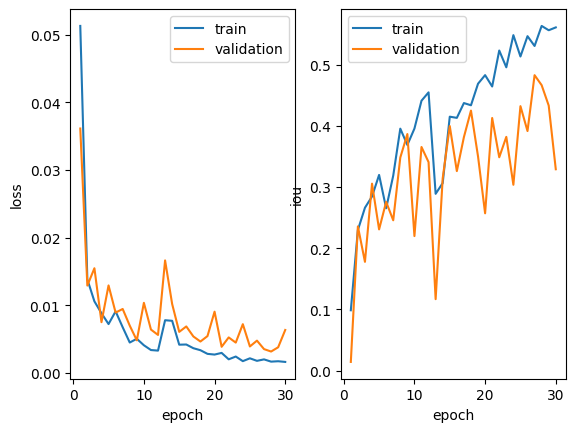

In [136]:
fig, axes = plt.subplots(1, 2)

axes[0].plot([i for i in range(1, epochs+1)], loss_tracking['train'], label='train')
axes[0].plot([i for i in range(1, epochs+1)], loss_tracking['val'], label='validation')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot([i for i in range(1, epochs+1)], iou_tracking['train'], label='train')
axes[1].plot([i for i in range(1, epochs+1)], iou_tracking['val'], label='validation')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('iou')
axes[1].legend()

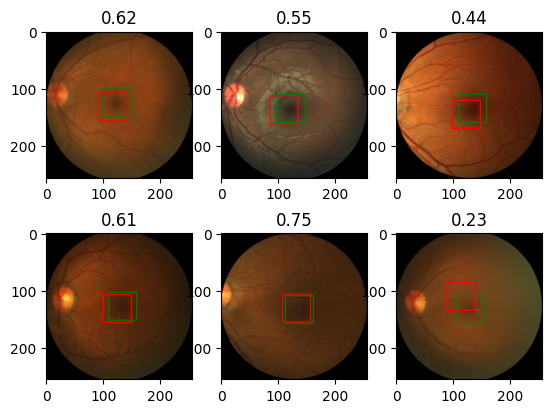

In [146]:
model.eval()

test_ds = test_dl.dataset
fig, axes = plt.subplots(2, 3)
to_draw = np.random.choice(range(len(test_ds)), size=6, replace=False)

for ax, idx in zip(axes.flatten(), to_draw):
	img, bbox = test_ds[idx]
	img, bbox = img.to(device), bbox.to(device)

	output = model(torch.unsqueeze(img, 0))
	iou = iou_batch(output, torch.unsqueeze(bbox, 0))

	_, target_bbox = ToPILImage()((img, bbox))
	img, eval_bbox = ToPILImage()((img, output.squeeze()))
	show_image_with_two_bboxes(img, target_bbox, eval_bbox, title=f'{iou:.2f}', ax=ax)